In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from config import DATA_PATH

%matplotlib inline

In [9]:
# read in pandas dataframes for service area, health centers, and health center ops/finance
service_sites = pd.read_csv(DATA_PATH + 'service_sites_df.csv')
service_area = pd.read_csv(DATA_PATH + 'service_area_df.csv')
health_centers = pd.read_csv(DATA_PATH + 'health_center_combined.csv')
health_center_ops_finance = pd.read_csv(DATA_PATH + 'health_center_ops_finance.csv')

Each dataframe has null values that will need to be delt with in differnt ways. 

## Service Area dataframe
I want to take a look at the service area dataframe to determine what values I'll keep for further analysis.

Null values in this dataframe represent zip codes where organizations have served patients but served between 1 and 15 people. Due to the small number of people being served in an area, the total number of patients is hidden to protect patient information. 

In [10]:
service_area.head()

,BHCMISID,GrantNumber,ReportingYear,ZipCode,ZipCodeType,None_UninsuredPatients,Medicaid_CHIP_OtherPublicPatients,MedicarePatients,PrivatePatients,TotalNumberofPatients
0,010030,H80CS00803,2022,1011,ZipCode,NaN,NaN,0.0,NaN,NaN
1,010030,H80CS00803,2022,1013,ZipCode,61.0,1346.0,385.0,182.0,1974.0
2,010030,H80CS00803,2022,1014,ZipCode,0.0,NaN,NaN,0.0,21.0
3,010030,H80CS00803,2022,1104,ZipCode,26.0,791.0,181.0,97.0,1095.0
4,010030,H80CS00803,2022,1108,ZipCode,25.0,640.0,79.0,61.0,805.0


In [11]:
service_area.isnull().sum()

BHCMISID                                 0
GrantNumber                              0
ReportingYear                            0
ZipCode                                  0
ZipCodeType                              0
None_UninsuredPatients               50399
Medicaid_CHIP_OtherPublicPatients    37127
MedicarePatients                     50594
PrivatePatients                      47475
TotalNumberofPatients                19381
dtype: int64

In [12]:
service_area.shape

(97142, 10)

My initial thoughts for this dataset are to count the total zip codes in each health center's defined service area for 2022. I may also want to see how many organizaions serve patients across states and counties. This will require joining this dataframe with another data source. I found US Zip Code and other geographical data at this [website](https://data.opendatasoft.com/explore/dataset/georef-united-states-of-america-zc-point%40public/table/?flg=en-us). I would need to call the API to get the state, county, zip code, and potentially other data as relevant.

In [13]:
health_center_zipcode_count = service_area.groupby('BHCMISID')['ZipCode'].count().reset_index(name='ZipCode_Count')\
                                .sort_values('ZipCode_Count', ascending=False)
health_center_zipcode_count.head(20)

,BHCMISID,ZipCode_Count
430,044310,771
194,02E00868,638
1228,09E01087,590
141,021510,584
448,0452150,544
1236,09E01141,533
401,042440,496
1159,094890,475
1145,093110,433
357,041020,409


In [14]:
health_center_zipcode_count.tail(10)

,BHCMISID,ZipCode_Count
1297,1012860,3
1132,0925390,3
1349,107930,3
1107,091920,3
1147,0931570,3
1154,093570,3
1178,099040,3
1312,1017080,3
1292,1011870,3
1369,11E01386,3


In [15]:
total_patients_and_zip_zero = service_area[(service_area['ZipCode'] == 0) & (service_area['TotalNumberofPatients'] == 0)]
total_patients_and_zip_zero.head()

,BHCMISID,GrantNumber,ReportingYear,ZipCode,ZipCodeType,None_UninsuredPatients,Medicaid_CHIP_OtherPublicPatients,MedicarePatients,PrivatePatients,TotalNumberofPatients
7,010030,H80CS00803,2022,0,Unknown Residence,0.0,0.0,0.0,0.0,0.0
64,010040,H80CS00443,2022,0,Unknown Residence,0.0,0.0,0.0,0.0,0.0
138,010060,H80CS00741,2022,0,Unknown Residence,0.0,0.0,0.0,0.0,0.0
277,010130,H80CS00002,2022,0,Unknown Residence,0.0,0.0,0.0,0.0,0.0
297,010150,H80CS00311,2022,0,Unknown Residence,0.0,0.0,0.0,0.0,0.0


After importing data, the zip code table had several rows where the zip code was missing, so I imputed these with 0 instead of the '-'. There are no single digit zip codes in general so they would be easy enough to find. 

I will remove rows for the health centers that did not list a zip code and served no patients so they won't influence the service area count table. 

I'll remove the rows where the zip code and total patients columns are 0 by creating a mask and removing these rows from the service area dataframe. 

In [16]:
total_patients_zero = (service_area['ZipCode'] == 0) & (service_area['TotalNumberofPatients'] == 0)
total_patients_zero.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [17]:
service_area_modified = service_area[~total_patients_zero]
service_area_modified.head()

,BHCMISID,GrantNumber,ReportingYear,ZipCode,ZipCodeType,None_UninsuredPatients,Medicaid_CHIP_OtherPublicPatients,MedicarePatients,PrivatePatients,TotalNumberofPatients
0,010030,H80CS00803,2022,1011,ZipCode,NaN,NaN,0.0,NaN,NaN
1,010030,H80CS00803,2022,1013,ZipCode,61.0,1346.0,385.0,182.0,1974.0
2,010030,H80CS00803,2022,1014,ZipCode,0.0,NaN,NaN,0.0,21.0
3,010030,H80CS00803,2022,1104,ZipCode,26.0,791.0,181.0,97.0,1095.0
4,010030,H80CS00803,2022,1108,ZipCode,25.0,640.0,79.0,61.0,805.0


I also want to look at which rows represent an unknown zip code but patients were served in that unknown area(s).

In [18]:
zipcode_zero = service_area_modified[(service_area_modified['ZipCode'] == 0) & (service_area_modified['TotalNumberofPatients'] != 0)]
zipcode_zero.shape

(1825, 10)

In [19]:
service_area_modified['ZipCodeType'].value_counts()

ZipCodeType
ZipCode              94402
Other ZIP Codes       1334
Unknown Residence      491
Name: count, dtype: int64

Most zip codes are known as they have been identified with the actual zip code where the patient lived when they received care. The other two zip code types represent the following:
1. Other ZIP Codes: Used when patients have a permanent residence outside the country or for entities to  combine and report patients from ZIP codes with 10 or fewer patients into one line.
2. Unknown Residence: Used when patients whose residence is not known or for whom a proxy zip code is not available.

I'll create a new dataframe to count the zip codes and patients for each health center. Note that the patient count will not include the rows with NaN values. The NaN values are not 0 but we will deal with this later in analysis. 

In [20]:
service_area_patients_count = service_area_modified.groupby('BHCMISID').agg({'ZipCode':'count', 'TotalNumberofPatients':'sum'})
service_area_patients_count.sort_values('ZipCode', ascending=False)

,ZipCode,TotalNumberofPatients
BHCMISID,,
044310,771,167375.0
02E00868,637,116157.0
09E01087,590,14293.0
021510,584,238961.0
0452150,542,56966.0
...,...,...
0925390,1,4508.0
091920,1,15456.0
099040,1,22646.0


/Users/katialopes-gilbert/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


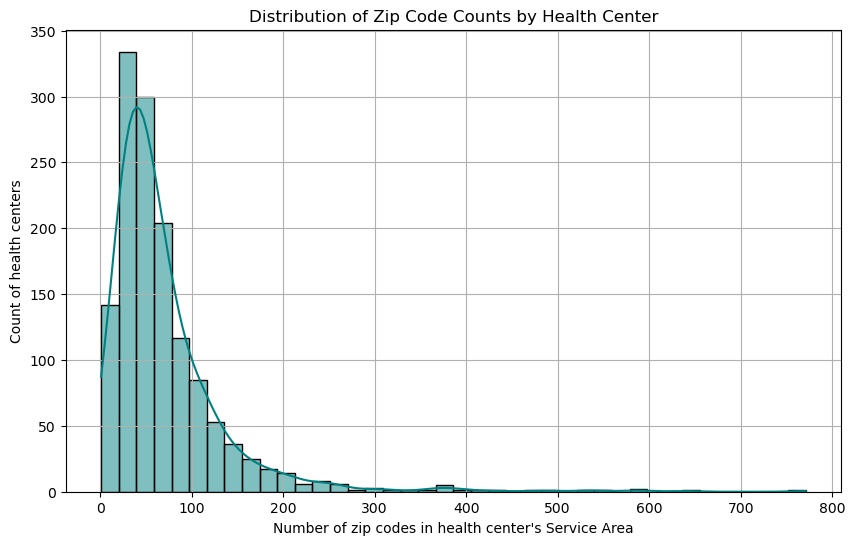

In [21]:
# create a histogram that shows the distribution of health center zip code counts
plt.figure(figsize=(10, 6))
sns.histplot(data=service_area_patients_count, x='ZipCode', bins=40, color='teal', kde=True)
plt.title('Distribution of Zip Code Counts by Health Center')
plt.xlabel("Number of zip codes in health center's Service Area")
plt.ylabel('Count of health centers')
plt.grid(True)
plt.show()

<Axes: xlabel='ZipCode'>

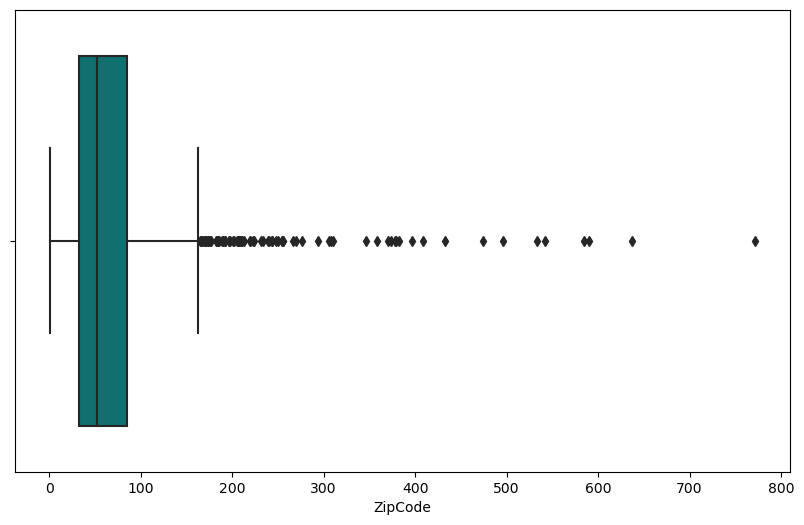

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=service_area_patients_count, x='ZipCode', color='teal')

In [23]:
service_area_patients_count['ZipCode'].describe()

count    1370.000000
mean       70.238686
std        68.081038
min         1.000000
25%        33.000000
50%        52.000000
75%        85.000000
max       771.000000
Name: ZipCode, dtype: float64

Most health centers have between 33 to 85 zip codes in their service area. However, there are several outliers that serve significantly larger geographic areas, with the most being nearly 800 zip codes. 

/Users/katialopes-gilbert/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


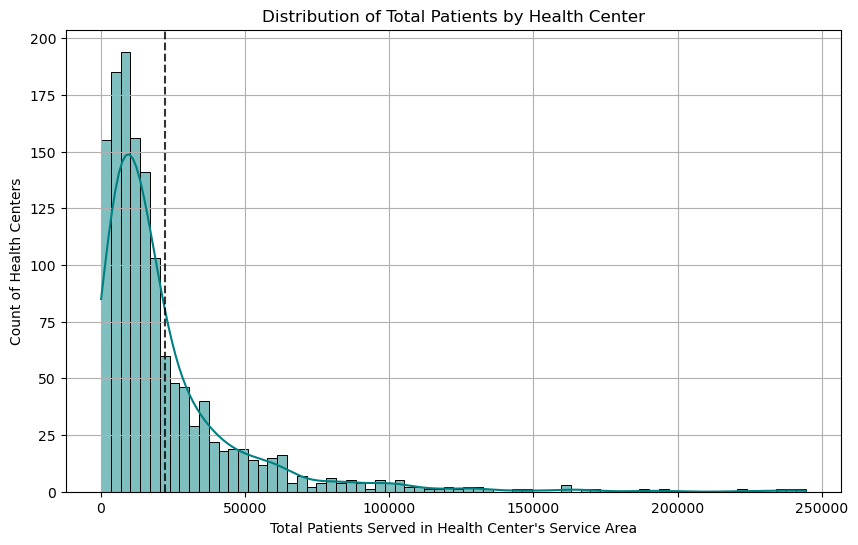

In [29]:
# create a histogram that shows the distribution of health center zip code counts
plt.figure(figsize=(10, 6))
sns.histplot(data=service_area_patients_count, x='TotalNumberofPatients', color='teal', kde=True)
plt.axvline(x=service_area_patients_count['TotalNumberofPatients'].mean(), c='black', ls='--', alpha=0.8, label='Avg Patients Served')
plt.title('Distribution of Total Patients by Health Center')
plt.xlabel("Total Patients Served in Health Center's Service Area")
plt.ylabel('Count of Health Centers')
plt.grid(True)
plt.show()

In [18]:
service_area_patients_count['TotalNumberofPatients'].describe()

count      1370.000000
mean      22146.730657
std       27214.703137
min         143.000000
25%        6971.250000
50%       13568.500000
75%       25933.750000
max      244362.000000
Name: TotalNumberofPatients, dtype: float64

Most health centers serve between 7,000 to 26,0000 patients. However, we see again that there are several outliers with one health center serving over 244,000 patients in 2022. 

**Q for Jyant: Would it make sense to categorize entities by their service area size and total patients served?**

# Health Centers Overall Dataframe

In [31]:
health_centers.isnull().sum()

BHCMISID                        0
GrantNumber                     0
HealthCenterName                0
HealthCenterCity                0
HealthCenterState               0
HealthCenterZIPCode             0
FundingCHC                      0
FundingMHC                      0
FundingHO                       0
FundingPH                       0
UrbanRuralFlag                  0
mhc_amount                      0
chc_amount                      0
ho_amount                       0
ph_amount                       0
total_hc_funding                0
bphc_total                      0
total_other_federal_grants      0
total_state_grants              0
total_private_grants            0
total_other_revenue             0
total_revenue                   0
total_male                      0
total_female                    0
asian                         156
native_hawaiian               681
pac_isl                       542
black                          63
am_ind                        332
white         

In [32]:
pd.options.display.float_format = '{:.2f}'.format

In [33]:
health_centers['total_hc_funding'].describe()

count       1370.00
mean     3680375.18
std      2742484.89
min       275778.00
25%      1806490.25
50%      2878258.50
75%      4605680.25
max     22382349.00
Name: total_hc_funding, dtype: float64

/Users/katialopes-gilbert/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


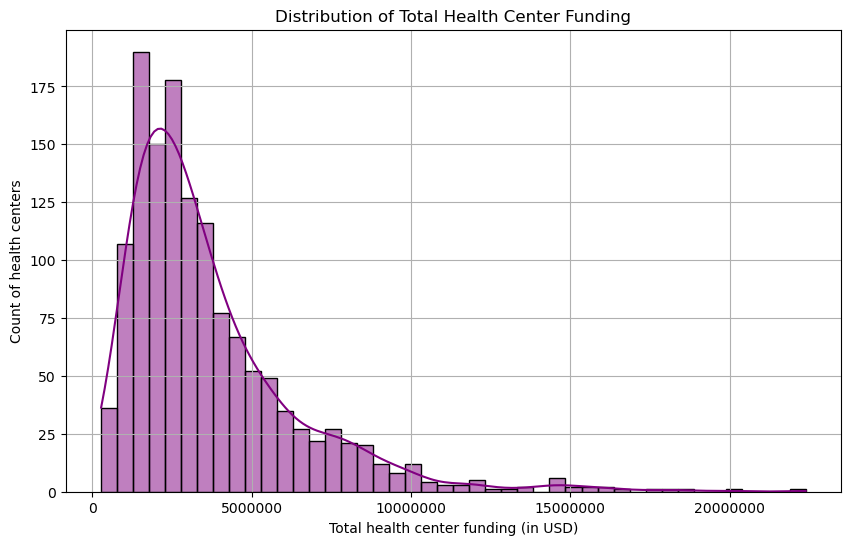

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=health_centers, x='total_hc_funding', color='purple', kde=True)
plt.title('Distribution of Total Health Center Funding')
plt.xlabel("Total health center funding (in USD)")
plt.ylabel('Count of health centers')
plt.ticklabel_format(style='plain')
plt.grid(True)
plt.show()

In [23]:
health_centers['UrbanRuralFlag'].value_counts()

UrbanRuralFlag
Urban    804
Rural    566
Name: count, dtype: int64

Most health centers are urban based, but there are also many rural health centers.

In [41]:
funding_grouping = health_centers.groupby('UrbanRuralFlag')['total_hc_funding'].sum().reset_index()
funding_grouping['perc_of_total_funding'] = (funding_grouping['total_hc_funding'] / funding_grouping['total_hc_funding'].sum())
funding_grouping

,UrbanRuralFlag,total_hc_funding,perc_of_total_funding
0,Rural,1810611907,0.36
1,Urban,3231502088,0.64


Most health center funding goes to entities in urban areas, which makes sense because they serve more people.

In [44]:
health_center_states = health_centers.groupby('HealthCenterState')['total_hc_funding'].sum().reset_index()
health_centers_states.columns = ['State', 'Number of Health Centers']
health_centers_states['% of All Health Centers'] = (health_centers_states['Number of Health Centers'] / len(health_centers) * 100).round(4)
health_centers_states

,HealthCenterState,total_hc_funding
0,AK,72200284
1,AL,88111298
2,AR,58549275
3,AS,2983180
4,AZ,88146154
5,CA,674381870
6,CO,106111822
7,CT,64213131
8,DC,28301917
9,DE,14345990


In [35]:
health_centers_states = health_centers['HealthCenterState'].value_counts().reset_index()
health_centers_states.columns = ['State', 'Number of Health Centers']
health_centers_states['% of All Health Centers'] = (health_centers_states['Number of Health Centers'] / len(health_centers) * 100).round(4)
health_centers_states

,State,Number of Health Centers,% of All Health Centers
0,CA,174,12.70
1,TX,72,5.26
2,NY,63,4.60
3,OH,51,3.72
4,FL,47,3.43
5,IL,45,3.28
6,PA,42,3.07
7,MI,39,2.85
8,NC,39,2.85
9,MA,37,2.70


California has the most number of health centers, with 12.7% of all health centers being based there. 

I see from this table that we also have data from several US territories, including the Virgin Islands, Palau, Guam, Marshall Islands, American Samoa, Micronesia, and the Norther Mariana Islands. I don't know if it will make sense to keep these for further analysis yet, but I will leave them for now. 

In [36]:
funding_types = health_centers[['BHCMISID','FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH']]
funding_types.head()

,BHCMISID,FundingCHC,FundingMHC,FundingHO,FundingPH
0,010030,True,False,False,False
1,010040,False,True,False,False
2,010060,True,False,False,False
3,010070,True,False,True,True
4,010120,False,False,True,False


In [26]:
health_center_ops_finance.isnull().sum()

BHCMISID                     0
GrantNumber                  0
HealthCenterName             0
HealthCenterCity             0
HealthCenterState            0
HealthCenterZIPCode          0
FundingCHC                   0
FundingMHC                   0
FundingHO                    0
FundingPH                    0
UrbanRuralFlag               0
total_costs_medical        629
total_costs_dental         629
total_costs_mh             629
total_costs_enabling       629
total_costs_quality        629
total_cost_care            629
total_charges              630
total_collected            630
total_sfs                  630
medical_clinic_visits      579
medical_virtual_visits     579
medical_patients           579
dental_clinic_visits       579
dental_virtual_visits      579
dental_patients            579
mh_clinic_visits           579
mh_virtual_visits          579
mh_patients                579
enabling_clinic_visits     579
enabling_virtual_visits    579
enabling_patients          579
total_cl